1) Buscar pregunta que se quiera responder utilizando los datos (ej: ¿Algún medio habla mas de política que otro medio?)

Posible pregunta:

- ¿Cómo los medios utilizan las palabras para hablar sobre violencia?

2) hacer analisis exploratorio de datos antes de desarrollar modelo de topicos

3) Desarrollar modelo


In [39]:
%matplotlib notebook

In [24]:
# Get data

# Import data
import pandas as pd
from IPython.display import display, HTML

# file name
file = 'MAD_violencia1.csv'

# load data
df = pd.read_csv(file, sep = '|', error_bad_lines = False, header = None)

# Parse to datetime format
df[0] = pd.to_datetime(df[0])

# Get date and news text
news = df[[0,1,3]]

# Shape of dataframe
display(news.shape)

# Columns
news.columns = ['date', 'company', 'news']

# text
news = news[0:100]

news.head()

(4468, 3)

,date,company,news
0,2017-05-23 10:40:09,lacuarta,Esto te interesa... 22/05/2017 - Autor: La Cu...
1,2017-05-18 12:59:58,RadioValparaiso,Portada » CIUDADES » Valparaíso » PDI DETIENE...
2,2017-06-01 22:40:30,araucanianews,"Jueves, 1 Junio, 2017 a las 22:39 Editor Actu..."
3,2017-06-01 08:20:07,chilevision,La Policía de Investigaciones detuvo a un hom...
4,2017-06-01 19:10:00,PublimetroChile,La Fuerza Artística de Choque Comunicativo or...


In [25]:
# Tokenizador

# Define own tokenizer
import spacy

nlp = spacy.load('es_core_news_sm')

def own_tokenizer(sentence):
    
    tokens = []
    
    doc = nlp(sentence.lower().strip())
    
    for token in doc:
        
        # Filtering
        if not token.is_space and not token.is_stop and not token.is_punct and not token.is_digit and not token.like_num:
            
            # add token to list in lemma form
            tokens.append(token.lemma_)
            
    return tokens

In [28]:
# Vectorizacion de textos usando TDIDF vectorizer

from sklearn.feature_extraction.text import CountVectorizer

# Stop words (not has information)
stop_words = ['a','e','i','o','u',' ','  ','   ','  ','  ','y']
# stop_words = ['a','e','i','o','u',' ','  ','   ','  ','$','  ','y']

# Vector representation of news
count_vectorizer = CountVectorizer(tokenizer = own_tokenizer, stop_words = stop_words, ngram_range = (1,2))

# Count vectorizer
news_vector_count = count_vectorizer.fit_transform(news['news'])

# Get features names
news_vector_features = count_vectorizer.get_feature_names()

Topic number 1 

Topic number 2 

Topic number 3 

Topic number 4 

Topic number 5 

Topic number 6 

Topic number 7 

Topic number 8 

Topic number 9 



<IPython.core.display.Javascript object>


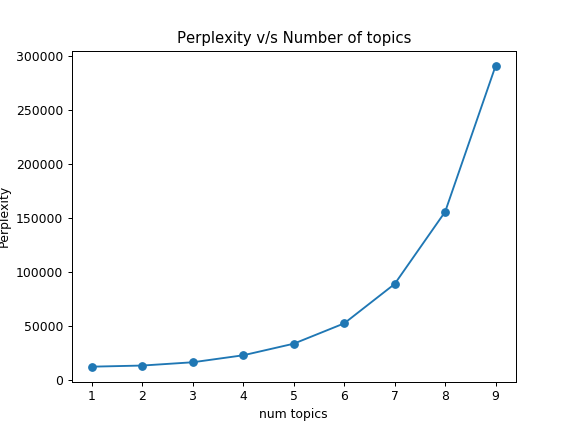

Text(0.5, 1.0, 'Perplexity v/s Number of topics')

In [56]:
# find optimal number of topics
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

# Perplexity list
perp = []

# number of topics
num_topic = range(1,10)

# Iter over each value of topic
for topic in num_topic:
    
    print('Topic number {0} \n'.format(topic))
    
    # Define lda model
    lda = LatentDirichletAllocation(n_components = topic, max_iter = 10,
      learning_method = 'online',
      learning_offset = 50,
      random_state = 0)
    
    # Fit model
    lda.fit(news_vector_count)
    
    # add perplexity
    perp.append(lda.perplexity(news_vector_count))
    
# Plot all k values
plt.plot(num_topic, perp, '-o')
plt.xlabel('num topics')
plt.ylabel('Perplexity')
plt.title('Perplexity v/s Number of topics')

Del gráfico se tiene que se definen 6 topicos, ya que para el 7 se observa aumento mayor que tasas anteriores.

In [58]:
# Define topics